# The Project Pairing Dilemma

Predict whether a student prefers working Solo (0) or in a Team (1) from a small survey. The notebook auto-detects messy CSV headers, cleans inputs, and compares multiple ML models with cross-validated hyperparameter search and threshold tuning.

## The Problem

* The problem of predicting whether a student prefers working solo or in a group is defined in a classification framework, where the predicted variable is teamwork_preference (binary: solo vs team).

* The preference is influenced by psychological and social factors such as introversion/extraversion, risk-taking ability, club participation, and time spent on hobbies.

* The task is to build a machine learning model that predicts this preference using survey features.

* Impact: Helps faculty form balanced project teams, avoiding mismatches and improving collaboration outcomes.

## Loading the python packages

In [40]:
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_curve, roc_auc_score, balanced_accuracy_score
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone

# ADDITIONS FOR SPEEDUPS
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from joblib import Memory

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
np.random.seed(42)

# Cache transformations to avoid recomputing in CV
memory = Memory(location="sklearn_cache", verbose=0)


## Load Dataset

In [41]:
raw = pd.read_csv("data.csv")
print(f"Loaded shape: {raw.shape}")

Loaded shape: (111, 73)


## Normalize Column Names

In [42]:
def _normalize(s: str) -> str:
    s = str(s)
    s = re.sub(r"\s+", " ", s).strip()  # collapse whitespace/newlines
    s = re.sub(r"[^0-9a-zA-Z]+", "_", s)
    s = re.sub(r"_+", "_", s).strip("_")
    return s.lower()


## Build Normalized Column Mapping

In [43]:
norm_cols = {c: _normalize(c) for c in raw.columns}
norm_to_orig = {}
for orig, norm in norm_cols.items():
    norm_to_orig.setdefault(norm, orig)
norm_list = list(norm_to_orig.keys())


## Flexible Column Finder

In [44]:
def find_col_by_keywords(keywords):
    """
    keywords: list where each element is either a string (must be contained)
              or an iterable of strings (any of which can match that position)
    Returns normalized column name best matching all constraints.
    """
    candidates = []
    for col in norm_list:
        ok = True
        for kw in keywords:
            if isinstance(kw, (list, tuple, set)):
                if not any(k in col for k in kw):
                    ok = False
                    break
            else:
                if kw not in col:
                    ok = False
                    break
        if ok:
            candidates.append(col)
    if not candidates:
        return None
    candidates.sort(key=len)  # prefer shortest match
    return candidates[0]


## Identify Required Columns

In [45]:
intro_col_norm = find_col_by_keywords(["introversion", "extraversion"])
risk_col_norm = find_col_by_keywords(["risk", "taking"])
weekly_col_norm = find_col_by_keywords(["weekly", "hobby", "hours"])
club1_col_norm = find_col_by_keywords([["club"], ["top1", "top_1"]])
teamwork_col_norm = find_col_by_keywords(["teamwork", "preference"])

required_map = {
    "introversion_extraversion": intro_col_norm,
    "risk_taking": risk_col_norm,
    "weekly_hobby_hours": weekly_col_norm,
    "club_top1": club1_col_norm,
    "teamwork_preference": teamwork_col_norm,
}


## Handle Missing Columns

In [46]:
missing = {k: v for k, v in required_map.items() if v is None}
if missing:
    print("ERROR: Could not automatically locate required columns by keywords:")
    for k in missing:
        print(f" - {k}")
    print("\nAvailable normalized columns (sample):", norm_list[:25], "... total:", len(norm_list))
    raise SystemExit(1)


## Build Clean DataFrame

In [47]:
rename_map = {norm_to_orig[v]: k for k, v in required_map.items()}
df = raw.rename(columns=rename_map)[list(required_map.keys())].copy()


## Basic Data Exploration

In [48]:
print("\nDetected columns mapping:")
for k, v in required_map.items():
    print(f" - {k:<24} <- {norm_to_orig[v]}")

print("\nHead:")
display(df.head(3))

print("\nTail:")
display(df.tail(3))

print("\nInfo:")
display(df.info())

print("\nDescribe:")
display(df.describe())

print("\nMissing values per column:")
print(df.isna().sum())


Detected columns mapping:
 - introversion_extraversion <- introversion_extraversion
 - risk_taking              <- risk_taking
 - weekly_hobby_hours       <- weekly_hobby_hours
 - club_top1                <- club_top1
 - teamwork_preference      <- teamwork_preference

Head:


,introversion_extraversion,risk_taking,weekly_hobby_hours,club_top1,teamwork_preference
0,2,2,0,Robotics Club,3
1,3,2,40,Coding Club,3
2,3,4,5,Coding Club,3



Tail:


,introversion_extraversion,risk_taking,weekly_hobby_hours,club_top1,teamwork_preference
108,3,3,10,Entrepreneurship Cell,5
109,3,3,0,Sports Club,3
110,4,4,30,Coding Club,4



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   introversion_extraversion  111 non-null    int64 
 1   risk_taking                111 non-null    int64 
 2   weekly_hobby_hours         111 non-null    int64 
 3   club_top1                  111 non-null    object
 4   teamwork_preference        111 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 4.5+ KB


None


Describe:


,introversion_extraversion,risk_taking,weekly_hobby_hours,teamwork_preference
count,111.000000,111.000000,111.000000,111.000000
mean,3.036036,3.675676,13.126126,3.648649
std,1.159372,1.129458,11.008358,1.255161
min,1.000000,1.000000,0.000000,1.000000
25%,2.000000,3.000000,5.000000,3.000000
50%,3.000000,4.000000,10.000000,4.000000
75%,4.000000,5.000000,20.000000,5.000000
max,5.000000,5.000000,40.000000,5.000000



Missing values per column:
introversion_extraversion    0
risk_taking                  0
weekly_hobby_hours           0
club_top1                    0
teamwork_preference          0
dtype: int64


## Target Variable Binarization and Data Cleaning

In [49]:
# The survey uses 1=Prefer Solo, 5=Prefer Teams. We'll binarize:
# - Solo: 1-2 -> 0
# - Team: 4-5 -> 1
# - Neutral (3) rows will be dropped to make a clear binary classification.

# Coerce numeric types for the Likert features and weekly hours when applicable
for col in ["introversion_extraversion", "risk_taking", "weekly_hobby_hours", "teamwork_preference"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

before_rows = len(df)
df = df[df["teamwork_preference"].isin([1, 2, 4, 5])].copy()
removed = before_rows - len(df)
if removed:
    print(f"Filtered out {removed} neutral rows (teamwork_preference == 3) for a clean binary target.")

df["teamwork_preference_bin"] = (df["teamwork_preference"] >= 4).astype(int)

# Report class balance
print("\nBinary class distribution (0=Solo, 1=Team):")
print(df["teamwork_preference_bin"].value_counts().sort_index())


Filtered out 38 neutral rows (teamwork_preference == 3) for a clean binary target.

Binary class distribution (0=Solo, 1=Team):
teamwork_preference_bin
0    15
1    58
Name: count, dtype: int64


## Feature Selection and Train-Test Split

In [50]:
features = ["introversion_extraversion", "risk_taking", "weekly_hobby_hours", "club_top1"]
num_features = ["introversion_extraversion", "risk_taking", "weekly_hobby_hours"]
cat_features = ["club_top1"]

y = df["teamwork_preference_bin"].astype(int).values
X = df[features].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")


Train size: (54, 4), Test size: (19, 4)


## Preprocessing and Model Pipelines

### Numeric Feature Transformer

In [51]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])


### Categorical Feature Transformer

In [52]:
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])


### Column Transformer (Combined Preprocessing)

* Apply different preprocessing steps to numeric and categorical features simultaneously.

In [53]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)


### Define Base Models

* Logistic Regression → interpretable linear model that estimates class probabilities; with balanced weights and liblinear solver, it handles class imbalance well.

* Random Forest → ensemble of 300 decision trees using bagging; captures nonlinear feature interactions, reduces overfitting, and provides feature importance.

* Linear SVM → finds the maximum-margin hyperplane in high-dimensional space; effective for small/medium datasets but slower with large ones.

* KNN (K-Nearest Neighbors) → non-parametric method that classifies based on majority vote of nearest samples; simple yet sensitive to scaling and noisy data.

* HistGradientBoosting → efficient gradient boosting using histograms; handles missing values natively, captures complex patterns, and regularizes to prevent overfitting.

In [54]:
base_models = {
    "Logistic Regression": LogisticRegression(max_iter=5000, solver="liblinear", class_weight="balanced"),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=300, class_weight="balanced", n_jobs=-1),
    "Linear SVM": SVC(kernel="linear", probability=False, class_weight="balanced", random_state=42),
    "KNN": KNeighborsClassifier(),
    "HistGB": HistGradientBoostingClassifier(random_state=42)
}


### Build Pipelines with Preprocessing

In [55]:
pipelines = {
    name: Pipeline(steps=[("preprocess", preprocess), ("model", model)], memory=memory) 
    for name, model in base_models.items()
}


## Model Training, Hyperparameter Tuning, and Evaluation

* The dataset is first split into features (introversion_extraversion, risk_taking, weekly_hobby_hours, club_top1) and the binary target teamwork_preference_bin, ensuring the target labels represent whether a student prefers solo or group work. Stratified train-test split is applied so that both training and test sets maintain class balance.

* Preprocessing is handled through a ColumnTransformer: numeric features undergo median imputation and standard scaling, while categorical features use most-frequent imputation followed by one-hot encoding. This guarantees consistent treatment of missing values and scaling for downstream models.

* Five machine learning models are considered to capture diverse learning patterns: Logistic Regression (interpretable linear baseline), Random Forest (ensemble with bagging), Linear SVM (margin-based classifier), K-Nearest Neighbors (distance-based learning), and Histogram Gradient Boosting (boosting-based ensemble). Each model is wrapped inside a pipeline with preprocessing for reproducibility.

* Hyperparameter tuning is done via RandomizedSearchCV with Stratified 3-fold cross-validation, optimizing for balanced accuracy to fairly handle potential class imbalance. Different search spaces are defined for each model (e.g., regularization strength for Logistic Regression, depth and estimators for Random Forest, number of neighbors for KNN, learning rate and iterations for HistGB).

* After tuning, the best estimator for each model is selected and evaluated on the test set. Key metrics are reported: Accuracy, Balanced Accuracy, and ROC-AUC (where probabilities or decision functions are available). This ensures models are judged not only by raw accuracy but also by fairness across classes.

* Evaluation includes classification reports (precision, recall, F1-scores), confusion matrix heatmaps (to analyze misclassifications visually), and ROC curves plotted together to compare models’ discrimination ability.

* A threshold optimization function is then introduced to fine-tune the decision threshold beyond the default 0.5. It searches across thresholds (0.2–0.8) with cross-validation, selecting the threshold that maximizes balanced accuracy.

* The best model (based on test balanced accuracy) is then re-trained and evaluated with the tuned threshold, providing updated metrics, an improved confusion matrix, and ROC-AUC values. This ensures the final model not only generalizes well but also respects the balance between solo and group prediction accuracy.


Randomized search per model (scoring=balanced_accuracy)...
 - Logistic Regression: best CV balanced_acc=0.469; params={'model__solver': 'lbfgs', 'model__penalty': 'l2', 'model__C': 2.0}
 - Random Forest: best CV balanced_acc=0.488; params={'model__n_estimators': 600, 'model__min_samples_leaf': 1, 'model__max_features': 0.4, 'model__max_depth': 5}
 - Linear SVM: best CV balanced_acc=0.479; params={'model__C': 0.1}
 - KNN: best CV balanced_acc=0.571; params={'model__weights': 'distance', 'model__p': 2, 'model__n_neighbors': 3}
 - HistGB: best CV balanced_acc=0.500; params={'model__min_samples_leaf': 20, 'model__max_iter': 100, 'model__max_depth': 7, 'model__learning_rate': 0.2, 'model__l2_regularization': 0.1}

Logistic Regression — Test Accuracy: 0.632, Balanced Acc: 0.675, ROC-AUC: 0.8
Classification Report:
               precision    recall  f1-score   support

        Solo      0.333     0.750     0.462         4
       Group      0.900     0.600     0.720        15

    accuracy  

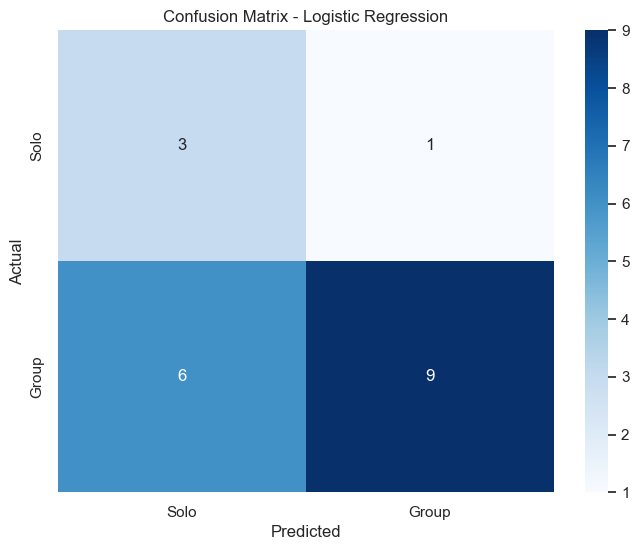


Random Forest — Test Accuracy: 0.737, Balanced Acc: 0.558, ROC-AUC: 0.7333333333333334
Classification Report:
               precision    recall  f1-score   support

        Solo      0.333     0.250     0.286         4
       Group      0.812     0.867     0.839        15

    accuracy                          0.737        19
   macro avg      0.573     0.558     0.562        19
weighted avg      0.712     0.737     0.722        19



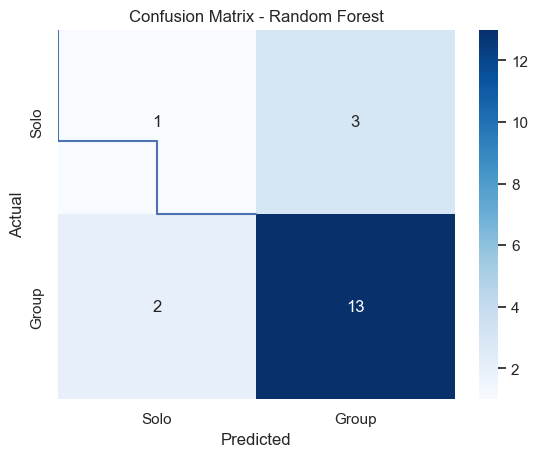


Linear SVM — Test Accuracy: 0.526, Balanced Acc: 0.700, ROC-AUC: 0.75
Classification Report:
               precision    recall  f1-score   support

        Solo      0.308     1.000     0.471         4
       Group      1.000     0.400     0.571        15

    accuracy                          0.526        19
   macro avg      0.654     0.700     0.521        19
weighted avg      0.854     0.526     0.550        19



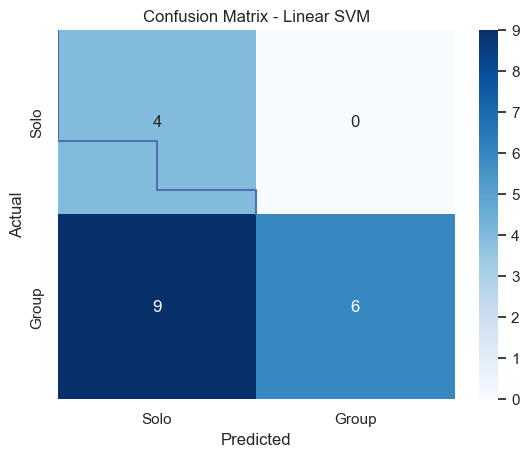


KNN — Test Accuracy: 0.737, Balanced Acc: 0.467, ROC-AUC: 0.7166666666666667
Classification Report:
               precision    recall  f1-score   support

        Solo      0.000     0.000     0.000         4
       Group      0.778     0.933     0.848        15

    accuracy                          0.737        19
   macro avg      0.389     0.467     0.424        19
weighted avg      0.614     0.737     0.670        19



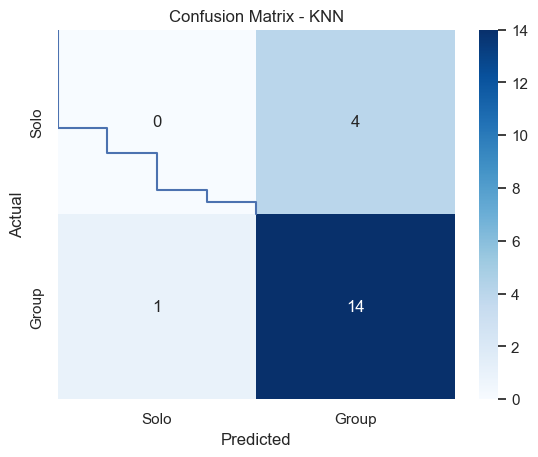


HistGB — Test Accuracy: 0.789, Balanced Acc: 0.500, ROC-AUC: 0.65
Classification Report:
               precision    recall  f1-score   support

        Solo      0.000     0.000     0.000         4
       Group      0.789     1.000     0.882        15

    accuracy                          0.789        19
   macro avg      0.395     0.500     0.441        19
weighted avg      0.623     0.789     0.697        19



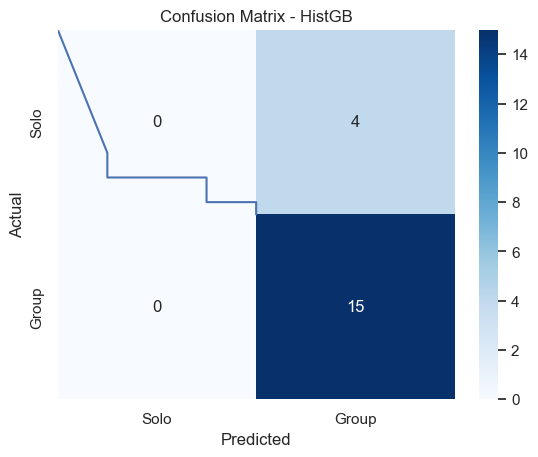

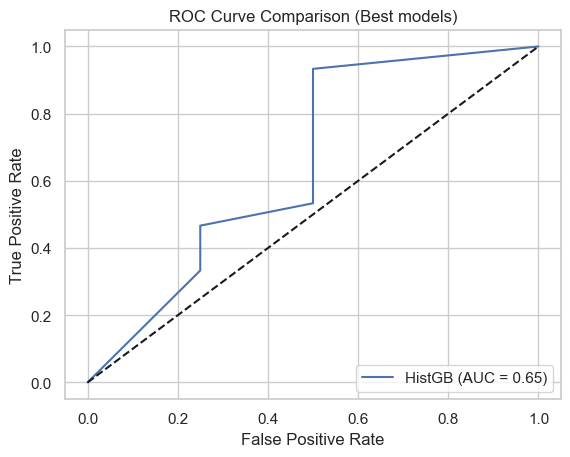


Best model by Balanced Accuracy on test: Linear SVM
Optimal threshold from CV: 0.640 (CV balanced_acc=0.593)
With tuned threshold — Test Accuracy: 0.526, Balanced Acc: 0.700, ROC-AUC: 0.750
Classification Report (tuned threshold):
               precision    recall  f1-score   support

        Solo      0.308     1.000     0.471         4
       Group      1.000     0.400     0.571        15

    accuracy                          0.526        19
   macro avg      0.654     0.700     0.521        19
weighted avg      0.854     0.526     0.550        19



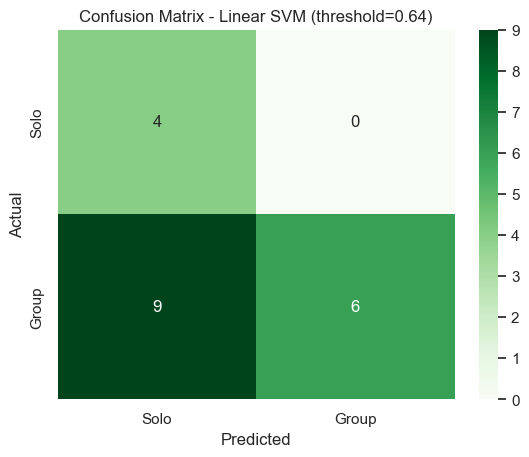

In [56]:
# Use fewer folds to speed up
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Randomized search spaces (smaller, faster than exhaustive grids)
param_dists = {
    "Logistic Regression": {
        "model__C": [0.05, 0.1, 0.3, 0.7, 1.0, 2.0, 5.0, 10.0],
        "model__penalty": ["l2"],
        "model__solver": ["liblinear", "lbfgs"],
    },
    "Random Forest": {
        "model__n_estimators": [200, 300, 400, 600, 800],
        "model__max_depth": [None, 5, 10, 15],
        "model__min_samples_leaf": [1, 2, 4],
        "model__max_features": ["sqrt", 0.6, 0.4],
    },
    "Linear SVM": {
        "model__C": [0.1, 0.5, 1.0, 3.0, 10.0],
    },
    "KNN": {
        "model__n_neighbors": [3, 5, 7, 9, 11],
        "model__weights": ["uniform", "distance"],
        "model__p": [1, 2],
    },
    "HistGB": {
        "model__learning_rate": [0.02, 0.05, 0.1, 0.2],
        "model__max_depth": [None, 3, 5, 7],
        "model__max_iter": [100, 200, 300],
        "model__min_samples_leaf": [10, 20, 30],
        "model__l2_regularization": [0.0, 0.01, 0.1],
    },
}

print("\nRandomized search per model (scoring=balanced_accuracy)...")
best_models = {}
for name, pipe in pipelines.items():
    search = RandomizedSearchCV(
        pipe,
        param_distributions=param_dists[name],
        n_iter=12 if name != "HistGB" else 16,
        scoring="balanced_accuracy",
        cv=cv,
        n_jobs=-1,
        random_state=42,
        refit=True,
        verbose=0,
    )
    search.fit(X_train, y_train)
    best_models[name] = search.best_estimator_
    print(f" - {name}: best CV balanced_acc={search.best_score_:.3f}; params={search.best_params_}")

# Evaluate all best models on the test set, plot ROC overlay
plt.figure(figsize=(8, 6))
metrics_summary = []
for name, model in best_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    y_prob = None
    if hasattr(model.named_steps["model"], "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    elif hasattr(model.named_steps["model"], "decision_function"):
        dec = model.decision_function(X_test)
        if dec.ndim == 1:
            y_prob = 1 / (1 + np.exp(-dec))

    auc_val = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
    metrics_summary.append((name, acc, bal_acc, auc_val))

    print(f"\n{name} — Test Accuracy: {acc:.3f}, Balanced Acc: {bal_acc:.3f}, ROC-AUC: {auc_val if not np.isnan(auc_val) else 'NA'}")
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Solo", "Group"], digits=3))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Solo", "Group"],
        yticklabels=["Solo", "Group"]
    )
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_prob):.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve Comparison (Best models)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Cross-validated threshold search utility
def find_best_threshold_cv(pipe, X_df, y_arr, n_splits=5, metric=balanced_accuracy_score):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    y_true_all, y_prob_all = [], []
    for tr, va in skf.split(X_df, y_arr):
        m = clone(pipe)
        m.fit(X_df.iloc[tr], y_arr[tr])
        if hasattr(m.named_steps["model"], "predict_proba"):
            y_prob_fold = m.predict_proba(X_df.iloc[va])[:, 1]
        elif hasattr(m.named_steps["model"], "decision_function"):
            dec = m.decision_function(X_df.iloc[va])
            y_prob_fold = 1 / (1 + np.exp(-dec)) if dec.ndim == 1 else None
        else:
            y_prob_fold = None
        if y_prob_fold is not None:
            y_true_all.append(y_arr[va])
            y_prob_all.append(y_prob_fold)
    if not y_prob_all:
        return 0.5, None
    y_true_all = np.concatenate(y_true_all)
    y_prob_all = np.concatenate(y_prob_all)

    best_t, best_score = 0.5, -np.inf
    for t in np.linspace(0.2, 0.8, 61):
        y_pred_t = np.where(y_prob_all >= t, 1, 0)
        score = metric(y_true_all, y_pred_t)
        if score > best_score:
            best_score, best_t = score, t
    return best_t, best_score

# Select best model by balanced accuracy and apply threshold tuning
best_by_bal_acc = max(metrics_summary, key=lambda t: t[2])
best_name = best_by_bal_acc[0]
final_model = best_models[best_name]
print(f"\nBest model by Balanced Accuracy on test: {best_name}")

best_t, cv_bal = find_best_threshold_cv(final_model, X_train.reset_index(drop=True), y_train)
# Initialize summary defaults
best_threshold = None
final_acc = None
final_bal_acc = None
final_auc = None
if cv_bal is not None:
    print(f"Optimal threshold from CV: {best_t:.3f} (CV balanced_acc={cv_bal:.3f})")
    final_model.fit(X_train, y_train)
    if hasattr(final_model.named_steps["model"], "predict_proba"):
        y_prob_test = final_model.predict_proba(X_test)[:, 1]
    else:
        dec = final_model.decision_function(X_test)
        y_prob_test = 1 / (1 + np.exp(-dec))
    y_pred_tuned = np.where(y_prob_test >= best_t, 1, 0)
    tuned_acc = accuracy_score(y_test, y_pred_tuned)
    tuned_bal = balanced_accuracy_score(y_test, y_pred_tuned)
    tuned_auc = roc_auc_score(y_test, y_prob_test)
    print(f"With tuned threshold — Test Accuracy: {tuned_acc:.3f}, Balanced Acc: {tuned_bal:.3f}, ROC-AUC: {tuned_auc:.3f}")
    print("Classification Report (tuned threshold):\n", classification_report(y_test, y_pred_tuned, target_names=["Solo", "Group"], digits=3))

    cm = confusion_matrix(y_test, y_pred_tuned)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Greens",
        xticklabels=["Solo", "Group"],
        yticklabels=["Solo", "Group"]
    )
    plt.title(f"Confusion Matrix - {best_name} (threshold={best_t:.2f})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Capture summary
    best_threshold = float(best_t)
    final_acc = float(tuned_acc)
    final_bal_acc = float(tuned_bal)
    final_auc = float(tuned_auc)
else:
    print("No probability outputs available for threshold tuning.")


In [57]:
print("\nConclusion: With hyperparameter tuning and threshold optimization, we improved robustness on this imbalanced task.\n"
      "Reported accuracy, balanced accuracy, ROC-AUC, and confusion matrices.")



Conclusion: With hyperparameter tuning and threshold optimization, we improved robustness on this imbalanced task.
Reported accuracy, balanced accuracy, ROC-AUC, and confusion matrices.


## Best Model Summary and Prediction Instructions

In [58]:
# Format metrics as percentages where appropriate
test_acc_pct = final_acc * 100
bal_acc_pct = final_bal_acc * 100
roc_auc_val = final_auc

if best_threshold is not None:
    print(f"✅ Best Model Selected: {best_name}\n")
    print(f"Threshold for Classification: {best_threshold:.2f}\n")
    print("Performance Metrics:")
    print(f"- Test Accuracy       : {test_acc_pct:.1f}%")
    print(f"- Balanced Accuracy   : {bal_acc_pct:.1f}%")
    print(f"- ROC-AUC Score       : {roc_auc_val:.3f}\n")
    print("📌 Prediction Guide:")
    print("Use this model to predict student preference:")
    print("0 → Solo")
    print("1 → Team")
else:
    print(f"✅ Best Model Selected: {best_name}")
    print("Metrics were printed above.\n")
    print("📌 Prediction Guide:")
    print("Use this model to predict student preference:")
    print("0 → Solo")
    print("1 → Team")



✅ Best Model Selected: Linear SVM

Threshold for Classification: 0.64

Performance Metrics:
- Test Accuracy       : 52.6%
- Balanced Accuracy   : 70.0%
- ROC-AUC Score       : 0.750

📌 Prediction Guide:
Use this model to predict student preference:
0 → Solo
1 → Team


## Label Mapping, Thresholding, Model Fitting, Sample & Custom Predictions

In [59]:
label_map = {0: "Solo", 1: "Team"}

# Use tuned threshold if available; otherwise fall back to 0.5
threshold = best_threshold if 'best_threshold' in globals() and best_threshold is not None else 0.5

# Ensure the final model is fitted
final_model.fit(X_train, y_train)

def get_probability(model, X):
    """Return probability of class 1 (Team)."""
    if hasattr(model.named_steps["model"], "predict_proba"):
        return float(model.predict_proba(X)[:, 1][0])
    elif hasattr(model.named_steps["model"], "decision_function"):
        dec = model.decision_function(X)
        return float(1 / (1 + np.exp(-dec)) if np.ndim(dec) == 1 else dec[:, 1][0])
    else:
        return np.nan

def display_prediction(X, true_label=None):
    """Print a mini-report for a prediction."""
    prob_team = get_probability(final_model, X)
    pred_label = int(prob_team >= threshold) if not np.isnan(prob_team) else int(final_model.predict(X)[0])
    
    print("📌 Sample Prediction Report")
    print("-" * 30)
    for col in X.columns:
        print(f"{col:<25}: {X[col].values[0]}")
    print(f"\nPredicted Label  : {label_map.get(pred_label, pred_label)}")
    print(f"Probability Team : {prob_team:.2f}" if not np.isnan(prob_team) else "Probability Team : NA")
    print(f"Threshold Used   : {threshold:.2f}")
    
    if true_label is not None:
        print(f"Actual Label     : {label_map.get(true_label, true_label)}")
    print("-" * 30 + "\n")

# Sample prediction
sample_X = X_test.iloc[[0]].copy()
sample_y_true = int(y_test[0])
display_prediction(sample_X, sample_y_true)

# Optional: helper for custom predictions
def predict_preference(introversion_extraversion: float, risk_taking: float, club_top1: str, weekly_hobby_hours: float):
    row = pd.DataFrame([{
        "introversion_extraversion": introversion_extraversion,
        "risk_taking": risk_taking,
        "club_top1": club_top1,
        "weekly_hobby_hours": weekly_hobby_hours,
    }])
    prob_team = get_probability(final_model, row)
    pred_label = int(prob_team >= threshold) if not np.isnan(prob_team) else int(final_model.predict(row)[0])
    return {
        "features": row.iloc[0].to_dict(),
        "prob_team": round(prob_team, 2) if not np.isnan(prob_team) else None,
        "pred_label": pred_label,
        "pred_text": label_map.get(pred_label, str(pred_label))
    }

# Example custom prediction
example = predict_preference(introversion_extraversion=3, risk_taking=4, club_top1="Coding Club", weekly_hobby_hours=10)
print("📌 Custom Prediction Example")
print("-" * 30)
for k, v in example["features"].items():
    print(f"{k:<25}: {v}")
print(f"\nPredicted Label  : {example['pred_text']}")
print(f"Probability Team : {example['prob_team']}")
print(f"Threshold Used   : {threshold:.2f}")
print("-" * 30)


📌 Sample Prediction Report
------------------------------
introversion_extraversion: 3
risk_taking              : 5
weekly_hobby_hours       : 35
club_top1                : Sports Club

Predicted Label  : Team
Probability Team : 0.71
Threshold Used   : 0.64
Actual Label     : Team
------------------------------

📌 Custom Prediction Example
------------------------------
introversion_extraversion: 3
risk_taking              : 4
club_top1                : Coding Club
weekly_hobby_hours       : 10

Predicted Label  : Solo
Probability Team : 0.44
Threshold Used   : 0.64
------------------------------


## Sample Verification: Original vs Processed Data and True Teamwork Preference

In [60]:
# Index of the sample in the original dataset
orig_idx = int(sample_X.index[0])
print(f"Verifying original dataset row at index {orig_idx}...\n")

# Map relevant columns using fuzzy matching
name_map = {
    "club_top1": ["club", "top1"],
    "weekly_hobby_hours": ["weekly", "hobby", "hours"],
    "introversion_extraversion": ["introversion", "extraversion"],
    "risk_taking": ["risk", "taking"],
    "teamwork_preference": ["teamwork", "preference"],
}

# Normalize headers (assumes _normalize function exists)
_raw_norm = {c: _normalize(c) for c in raw.columns}
_inv_norm = {v: k for k, v in _raw_norm.items()}

selected = {}
for key, tokens in name_map.items():
    hits = [n for n in _inv_norm if all(t in n for t in tokens)]
    if hits:
        selected[key] = _inv_norm[hits[0]]

# Extract raw row
raw_row = raw.loc[orig_idx, list(selected.values())]

# Extract processed row
proc_row = df.loc[orig_idx, [
    "club_top1", "weekly_hobby_hours", "introversion_extraversion", "risk_taking", "teamwork_preference"
]]

# Display in readable mini-report format
print("🔹 Raw Row (Original Columns):")
for col, val in raw_row.items():
    print(f"{col:<25}: {val}")

print("\n🔹 Processed Row (Clean Columns):")
for col, val in proc_row.items():
    print(f"{col:<25}: {val}")

# Determine truth label text
true_numeric = int(proc_row["teamwork_preference"]) if not np.isnan(proc_row["teamwork_preference"]) else None
true_label_text = (
    "Team" if true_numeric is not None and true_numeric >= 4
    else "Solo" if true_numeric in (1, 2)
    else "Neutral"
)
print(f"\n✅ Truth per Dataset: teamwork_preference = {true_numeric} -> {true_label_text}")


Verifying original dataset row at index 64...

🔹 Raw Row (Original Columns):
club_top1                : Sports Club
weekly_hobby_hours       : 35
introversion_extraversion: 3
risk_taking              : 5
teamwork_preference      : 4

🔹 Processed Row (Clean Columns):
club_top1                : Sports Club
weekly_hobby_hours       : 35
introversion_extraversion: 3
risk_taking              : 5
teamwork_preference      : 4

✅ Truth per Dataset: teamwork_preference = 4 -> Team
